# <div class="alert alert-info"><strong>Тестовое задание: Прогнозирование качества вин</strong></div>
# <span style='color:blue'>Суворов Андрей Вячеславович</span>
# Разработчик нейронных сетей / AI-инженер
Цель работы: Создать модель, которая будет предсказывать качество вина на основе его свойств.<br>

## <font color='green'>Импортируем библиотеки и загружаем исходные данные: <font>

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

file1 = r"/content/winequality-red.csv"

df_winequality_red = pd.read_csv(file1, sep=';')

## <font color='green'>Получим общую информацию о DataFrame, включая типы данных и количество непустых значений: <font>

In [60]:
df_winequality_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## <font color='green'>Смотрим на основные статистические характеристики: <font>

In [61]:
df_winequality_red.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [62]:
count_unique_red = df_winequality_red.nunique()
duplicates_red = df_winequality_red.duplicated().sum()

print(f"Количество уникальных значений white: {count_unique_red}")
print(f"Количество дубликатов в white: {duplicates_red}")

Количество уникальных значений white: fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64
Количество дубликатов в white: 240


## <font color='green'>Визуализируем df: <font>

df_winequality_red (1599, 12)


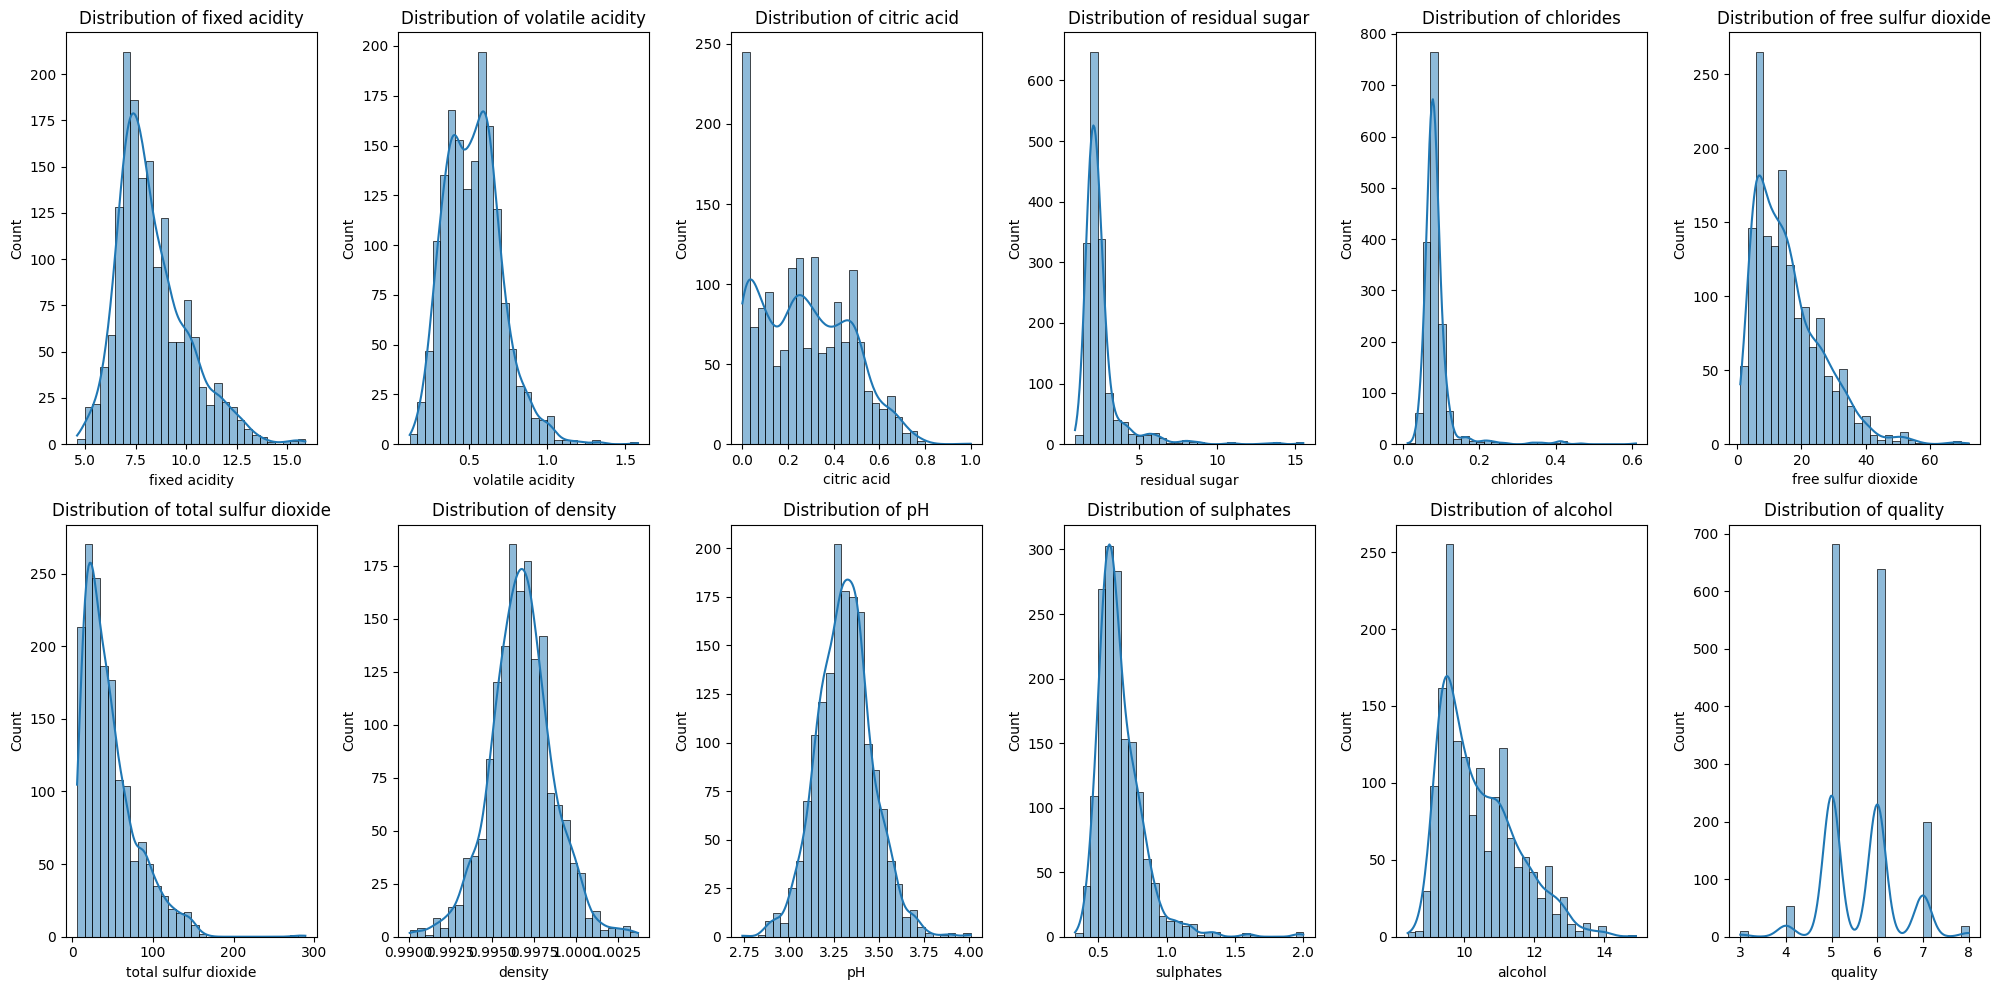

In [64]:
df_winequality_red.replace([np.inf, -np.inf], np.nan, inplace=True)

print("df_winequality_red", df_winequality_red.shape)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(df_winequality_red.columns):
    sns.histplot(df_winequality_red[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Распределение относительно нормальное, но смещено влево. Имеются пики. "alcohol", "residual_sugar" "chlorides" - распределены не нормально.

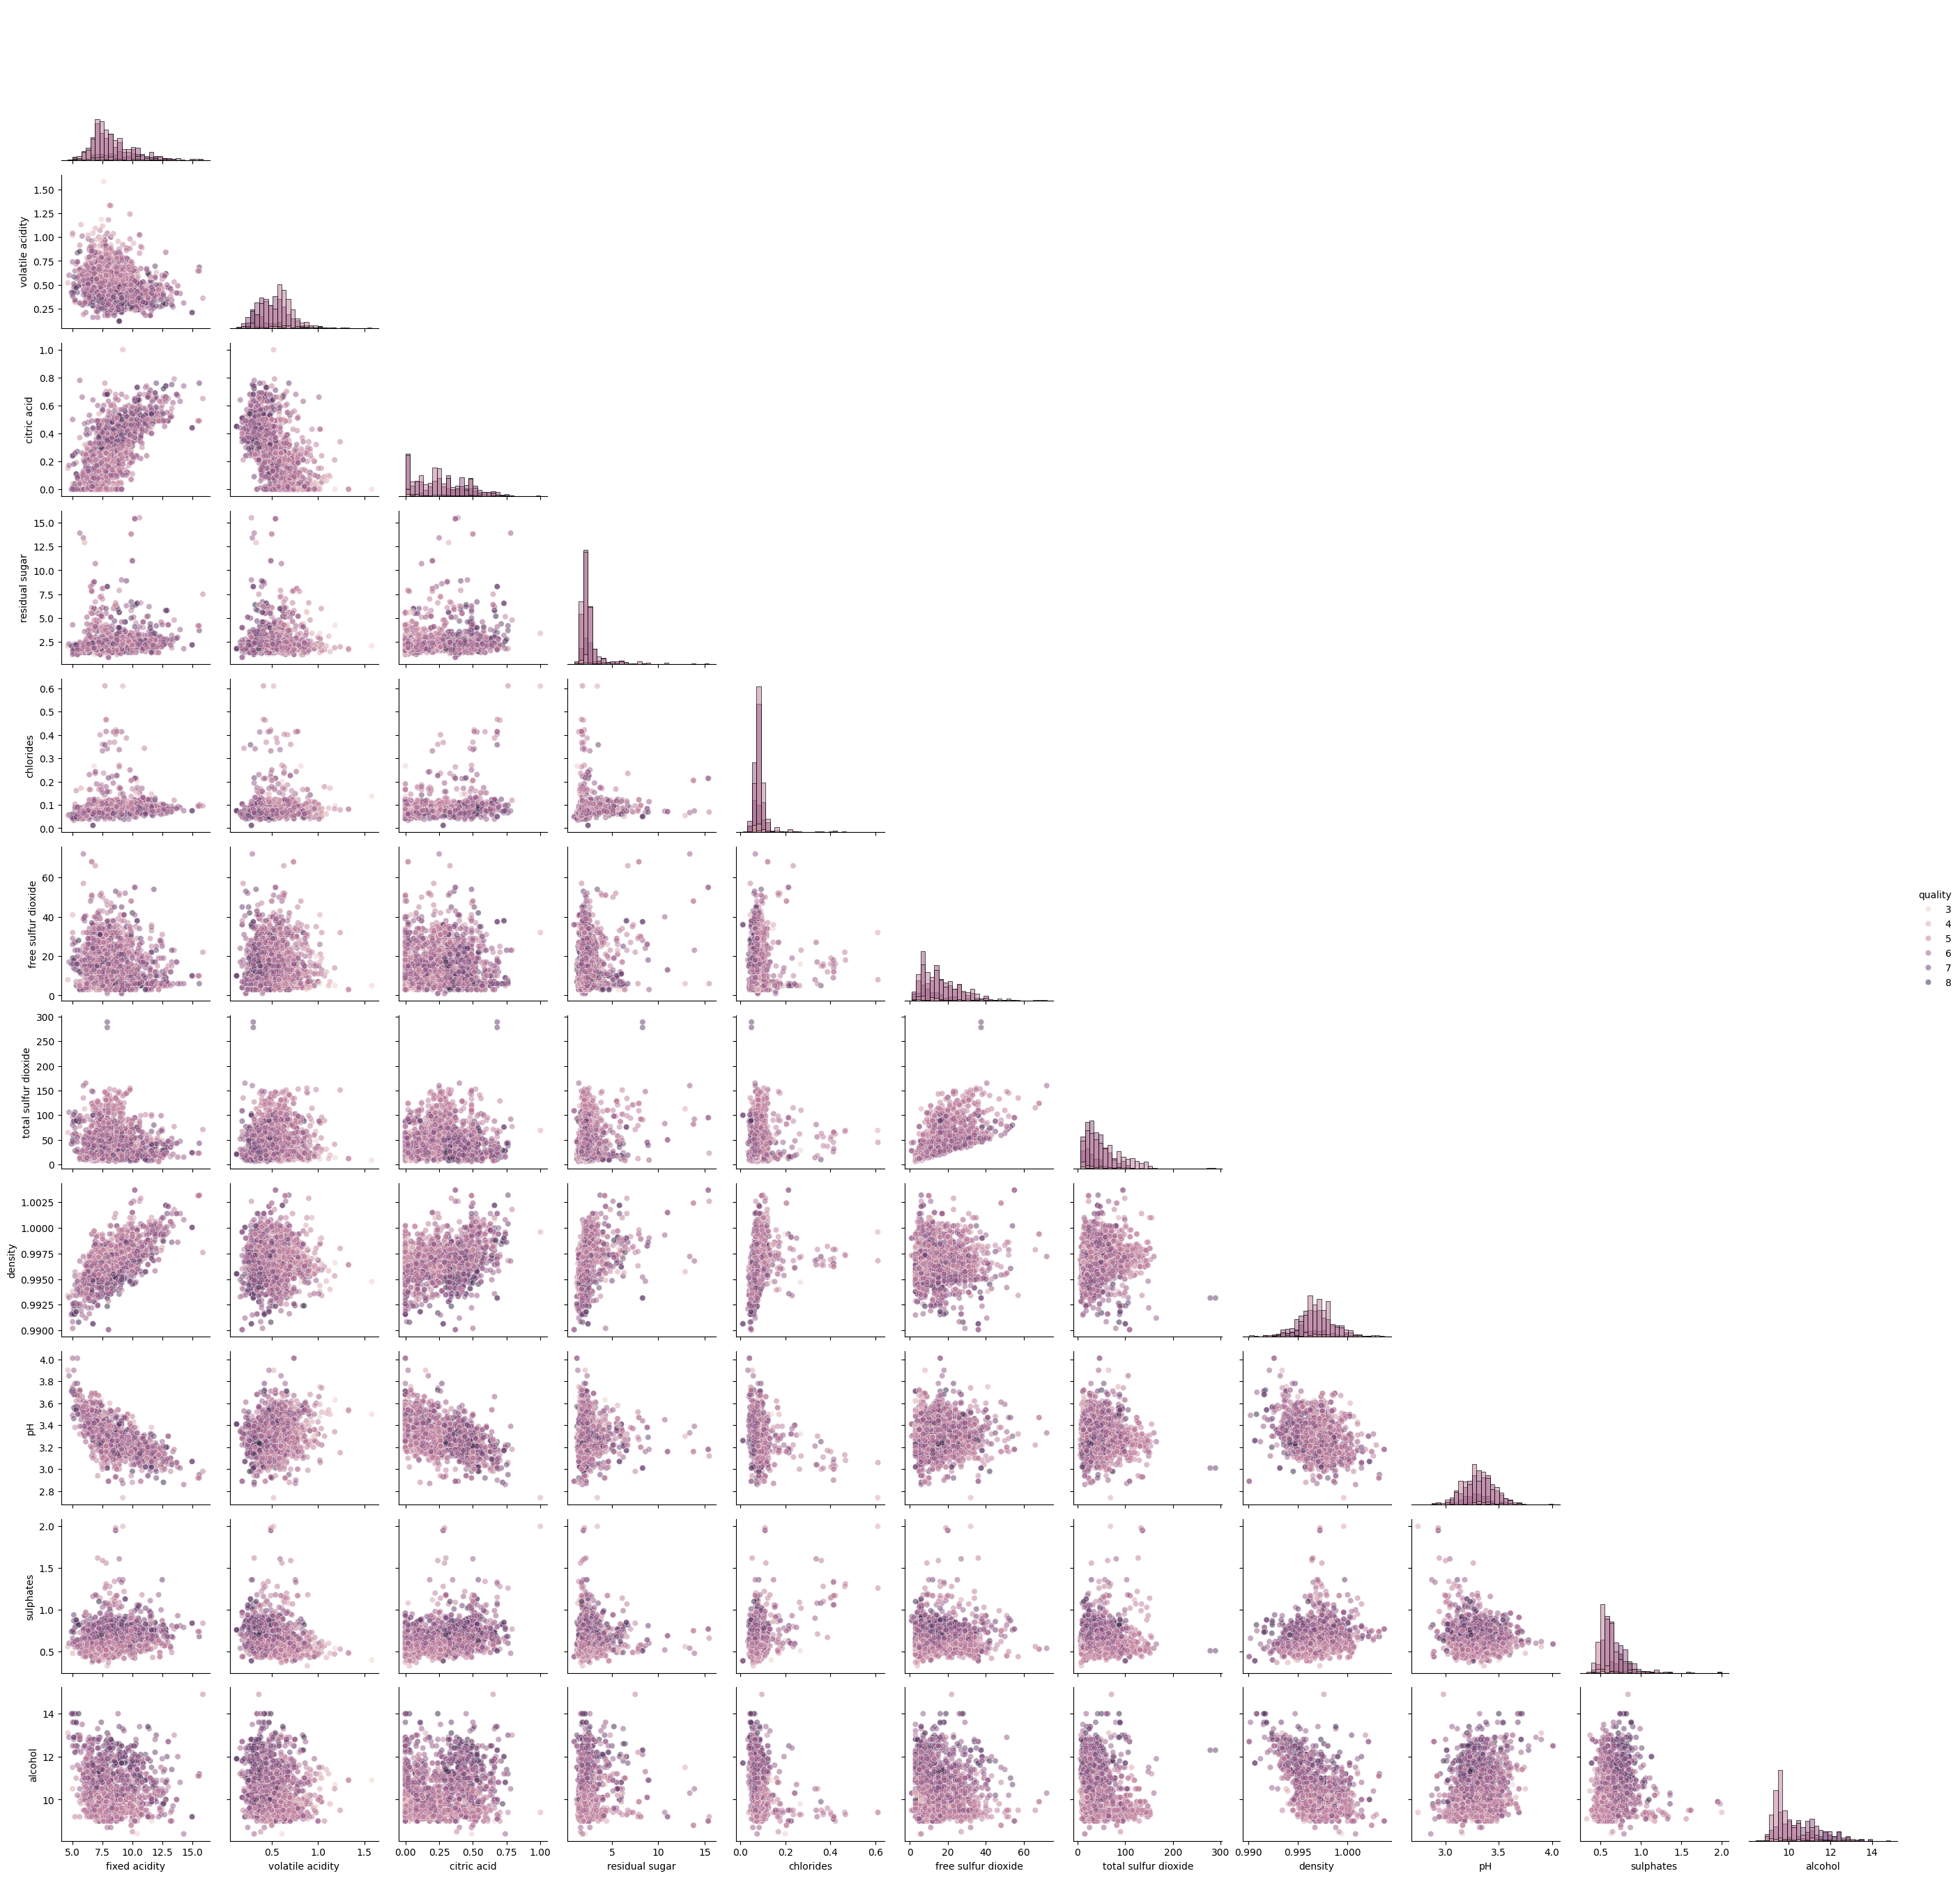

In [65]:
g = sns.PairGrid(df_winequality_red, hue="quality", corner=True)
g.map_lower(sns.scatterplot, alpha=0.5)
g.map_diag(sns.histplot, bins=30)
g.add_legend()
plt.show()

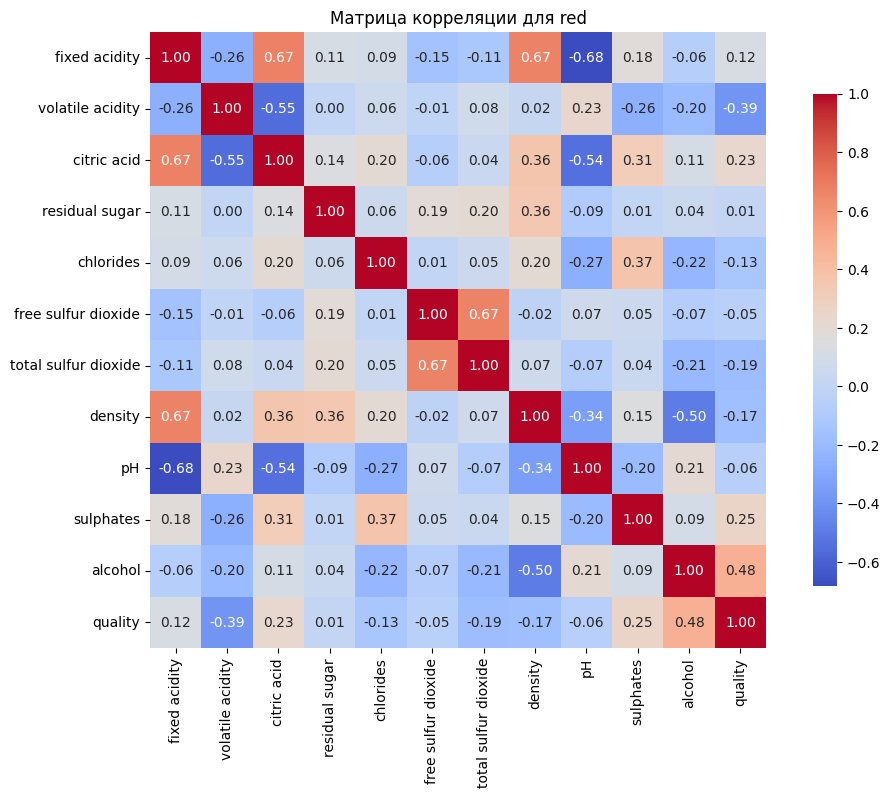

In [66]:
correlation_matrix = df_winequality_red.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляции для red')
plt.show()

# Некоторые значения имееют линейную зависимость, положительную или отрицательную.

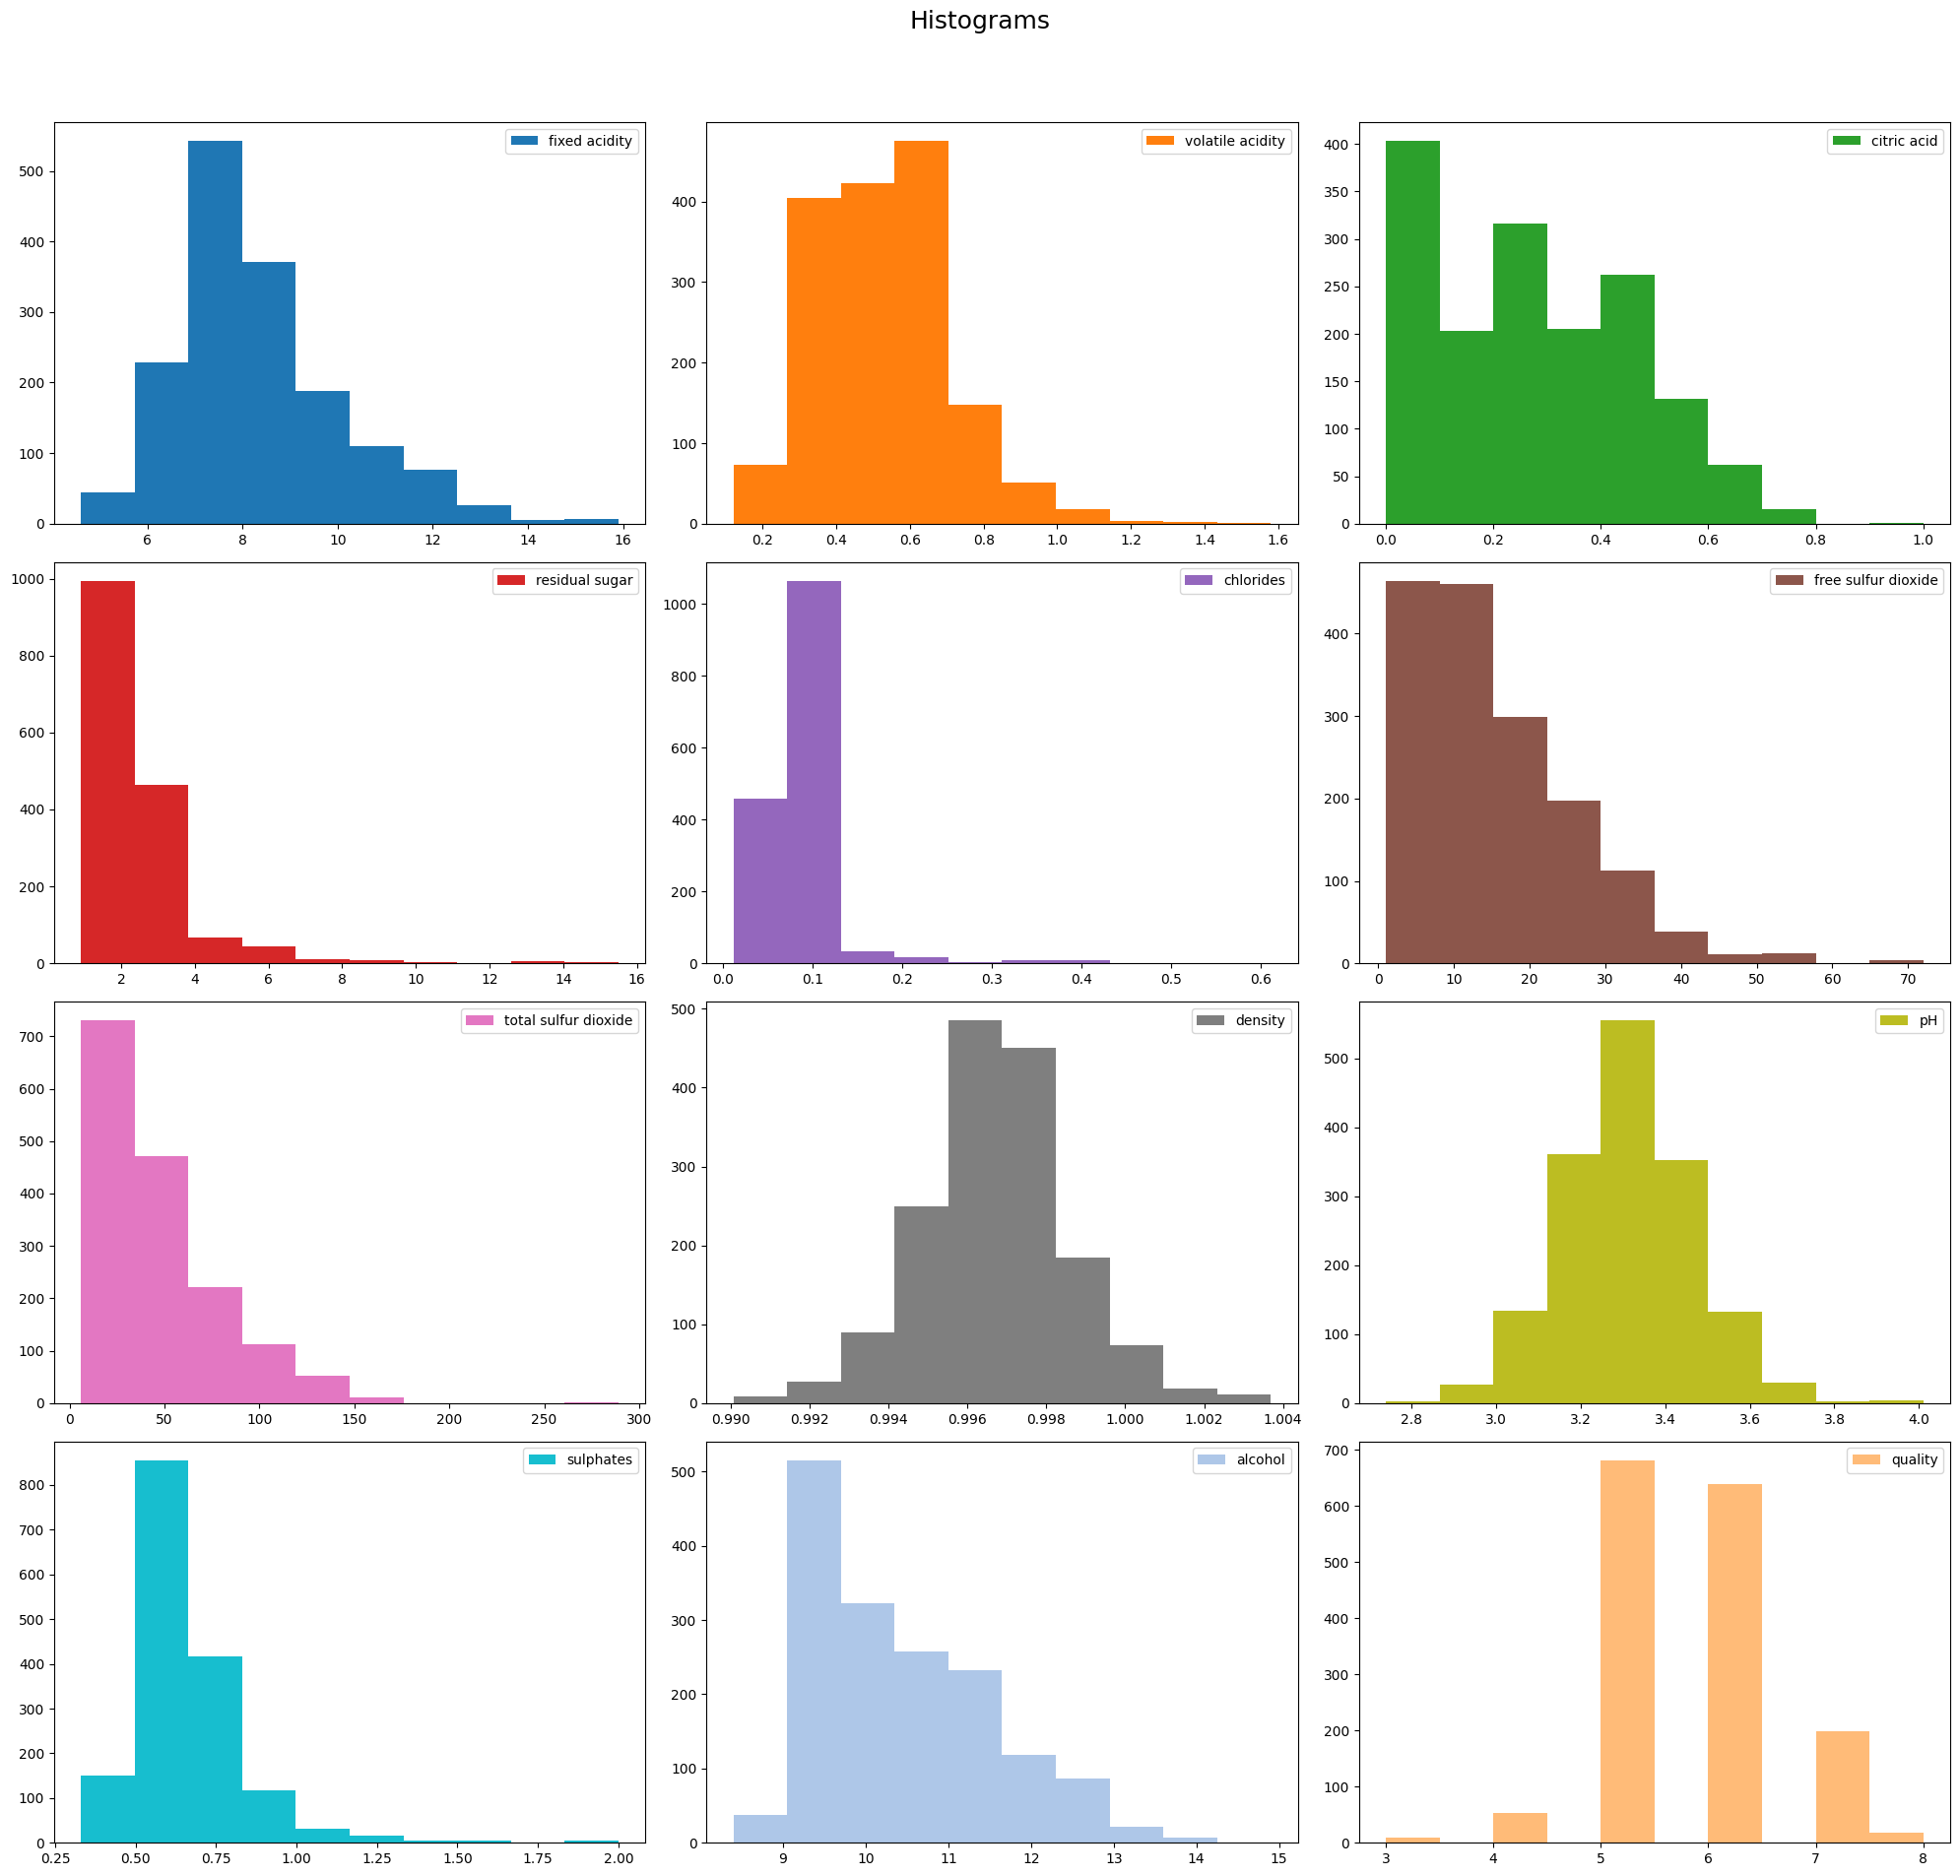

In [67]:
n_cols = len(df_winequality_red.columns)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(20, 20))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']

for index, column in enumerate(df_winequality_red.columns):
    ax = axes.flatten()[index]
    ax.hist(df_winequality_red[column], color=colors[index % len(colors)], label=column)
    ax.legend(loc="best")

for ax in axes.flatten()[n_cols:]:
    ax.set_visible(False)

plt.suptitle("Histograms", size=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Большинство значений переменной "фиксированная кислотность" находятся в диапазоне от 7 до 8;

Большинство значений переменной "летучая кислотность" находятся в диапазоне от 0,4 до 0,7;

Большинство значений переменной "citric_acid" находятся в диапазоне от 0,0 до 0,1;

Большинство значений переменной "остаточный_сахар" находятся в диапазоне от 1 до 2,5;

Большинство значений переменной "chlorides" находятся в диапазоне 0,085 - 0,15;

Большинство значений переменной "free_sulfur_dioxide" находятся в диапазоне 0-15;

Большинство значений переменной "total_sulfur_dioxide" находятся в диапазоне от 0 до 30;

Большинство значений параметра "плотность" находятся в диапазоне 0,996 - 0,998;

Большинство значений параметра "рН" находятся в диапазоне 3,2 - 3,4;

Большинство значений переменной "сульфаты" находятся в диапазоне 0,50 - 0,75;

Большинство значений переменной "алкоголь" находятся в диапазоне 9-10;

Большинство значений переменной "качество" равны 5 и 6.

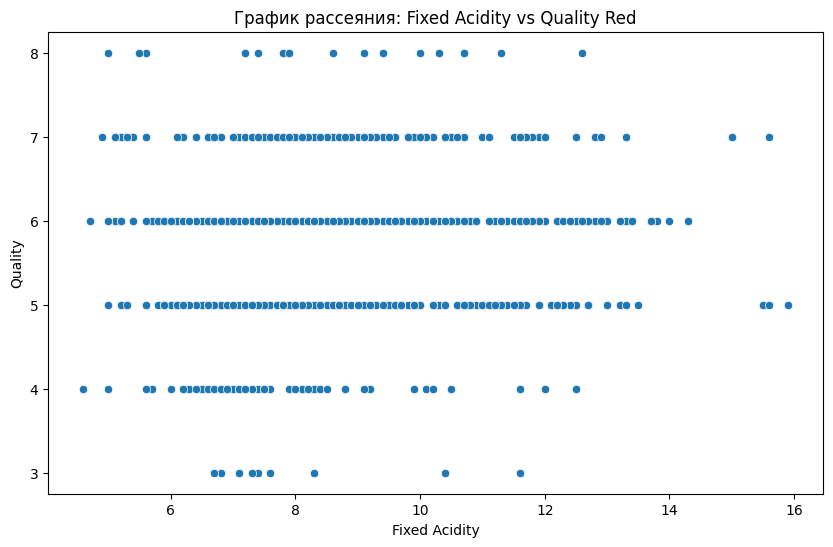

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='quality', data=df_winequality_red)
plt.title('График рассеяния: Fixed Acidity vs Quality Red')
plt.xlabel('Fixed Acidity')
plt.ylabel('Quality')
plt.show()

In [69]:
Q1 = df_winequality_red.quantile(0.25)
Q3 = df_winequality_red.quantile(0.75)
IQR = Q3 - Q1

outliers_red = ((df_winequality_red < (Q1 - 1.5 * IQR)) | (df_winequality_red > (Q3 + 1.5 * IQR)))
print("Количество выбросов по каждому признаку red:")
print(outliers_red.sum())

Количество выбросов по каждому признаку red:
fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      30
total sulfur dioxide     55
density                  45
pH                       35
sulphates                59
alcohol                  13
quality                  28
dtype: int64


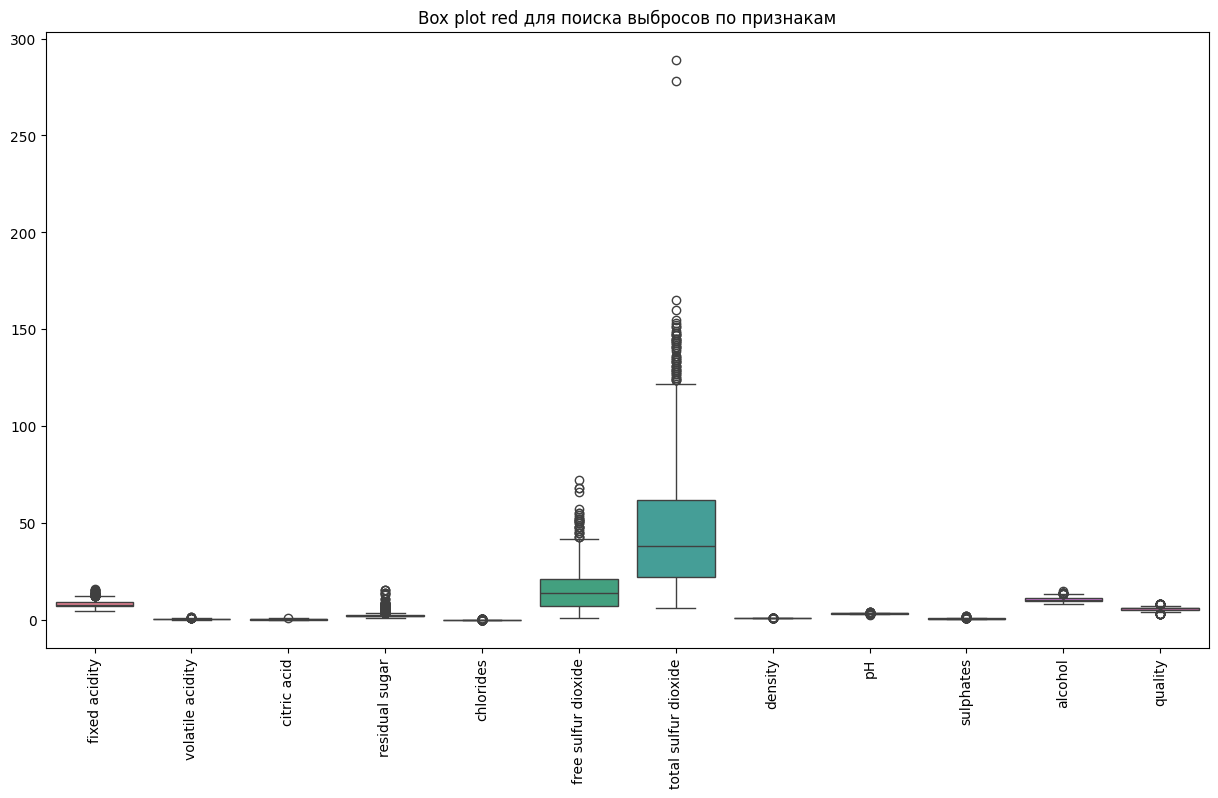

In [70]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_winequality_red)
plt.xticks(rotation=90)
plt.title("Box plot red для поиска выбросов по признакам")
plt.show()

# Видны значения которые выглядят как выбросы

## <font color='green'>Метод решения №1: <font>

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


R-squared: 0.36
Mean Absolute Error: 0.50


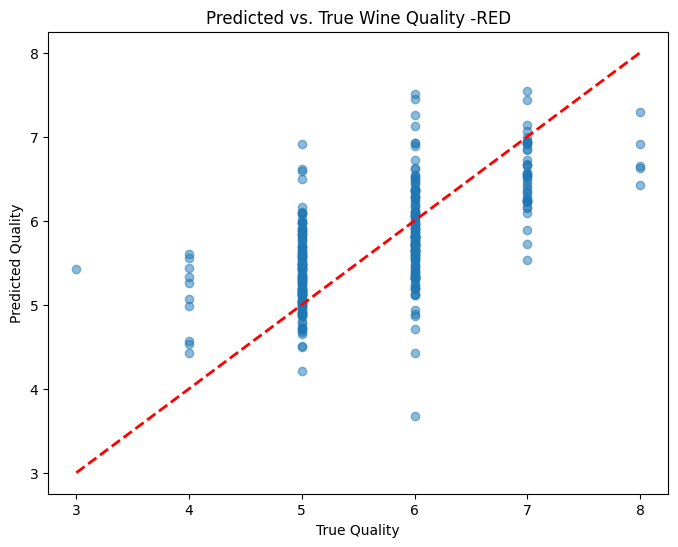

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wine_data_scaled_red = scaler.fit_transform(df_winequality_red.drop('quality', axis=1))
wine_data_scaled_red = pd.DataFrame(wine_data_scaled_red, columns=df_winequality_red.drop('quality', axis=1).columns)
df_winequality_red['quality'] = df_winequality_red['quality']

X = wine_data_scaled_red
y = df_winequality_red['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs. True Wine Quality -RED')
plt.show()

## <font color='green'>Метод решения №2: <font>

R-squared: 0.46
Mean Absolute Error: 0.48


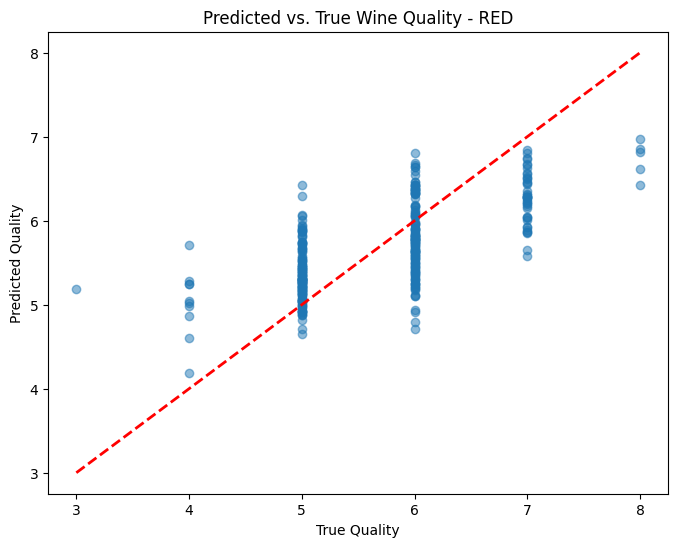

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
wine_data_scaled_red = scaler.fit_transform(df_winequality_red.drop('quality', axis=1))
wine_data_scaled_red = pd.DataFrame(wine_data_scaled_red, columns=df_winequality_red.drop('quality', axis=1).columns)

df_winequality_red['quality'] = df_winequality_red['quality']

X = wine_data_scaled_red
y = df_winequality_red['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs. True Wine Quality - RED')
plt.show()

## <font color='green'>Попробую, удалить выбросы: <font>

In [71]:
file2 = r"/content/winequality-red.csv"

df_winequality_red2 = pd.read_csv(file2, sep=';')

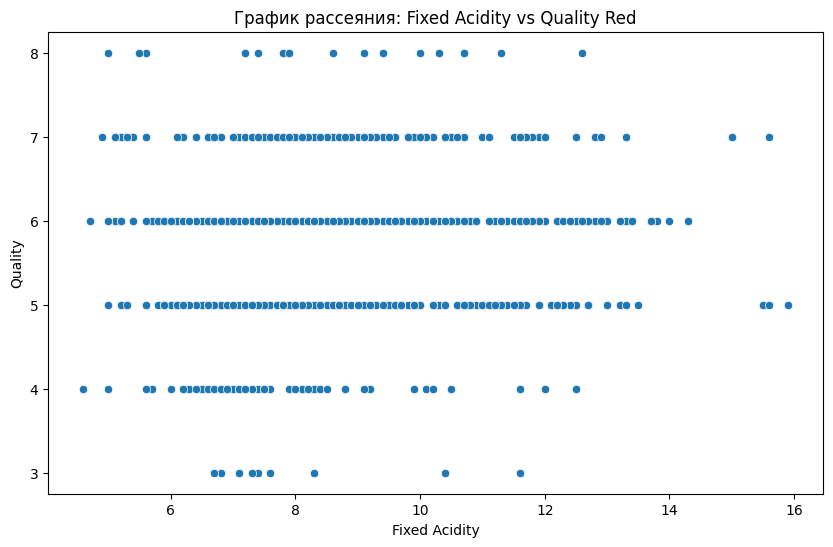

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='quality', data=df_winequality_red)
plt.title('График рассеяния: Fixed Acidity vs Quality Red')
plt.xlabel('Fixed Acidity')
plt.ylabel('Quality')
plt.show()

df_winequality_red (1599, 12)


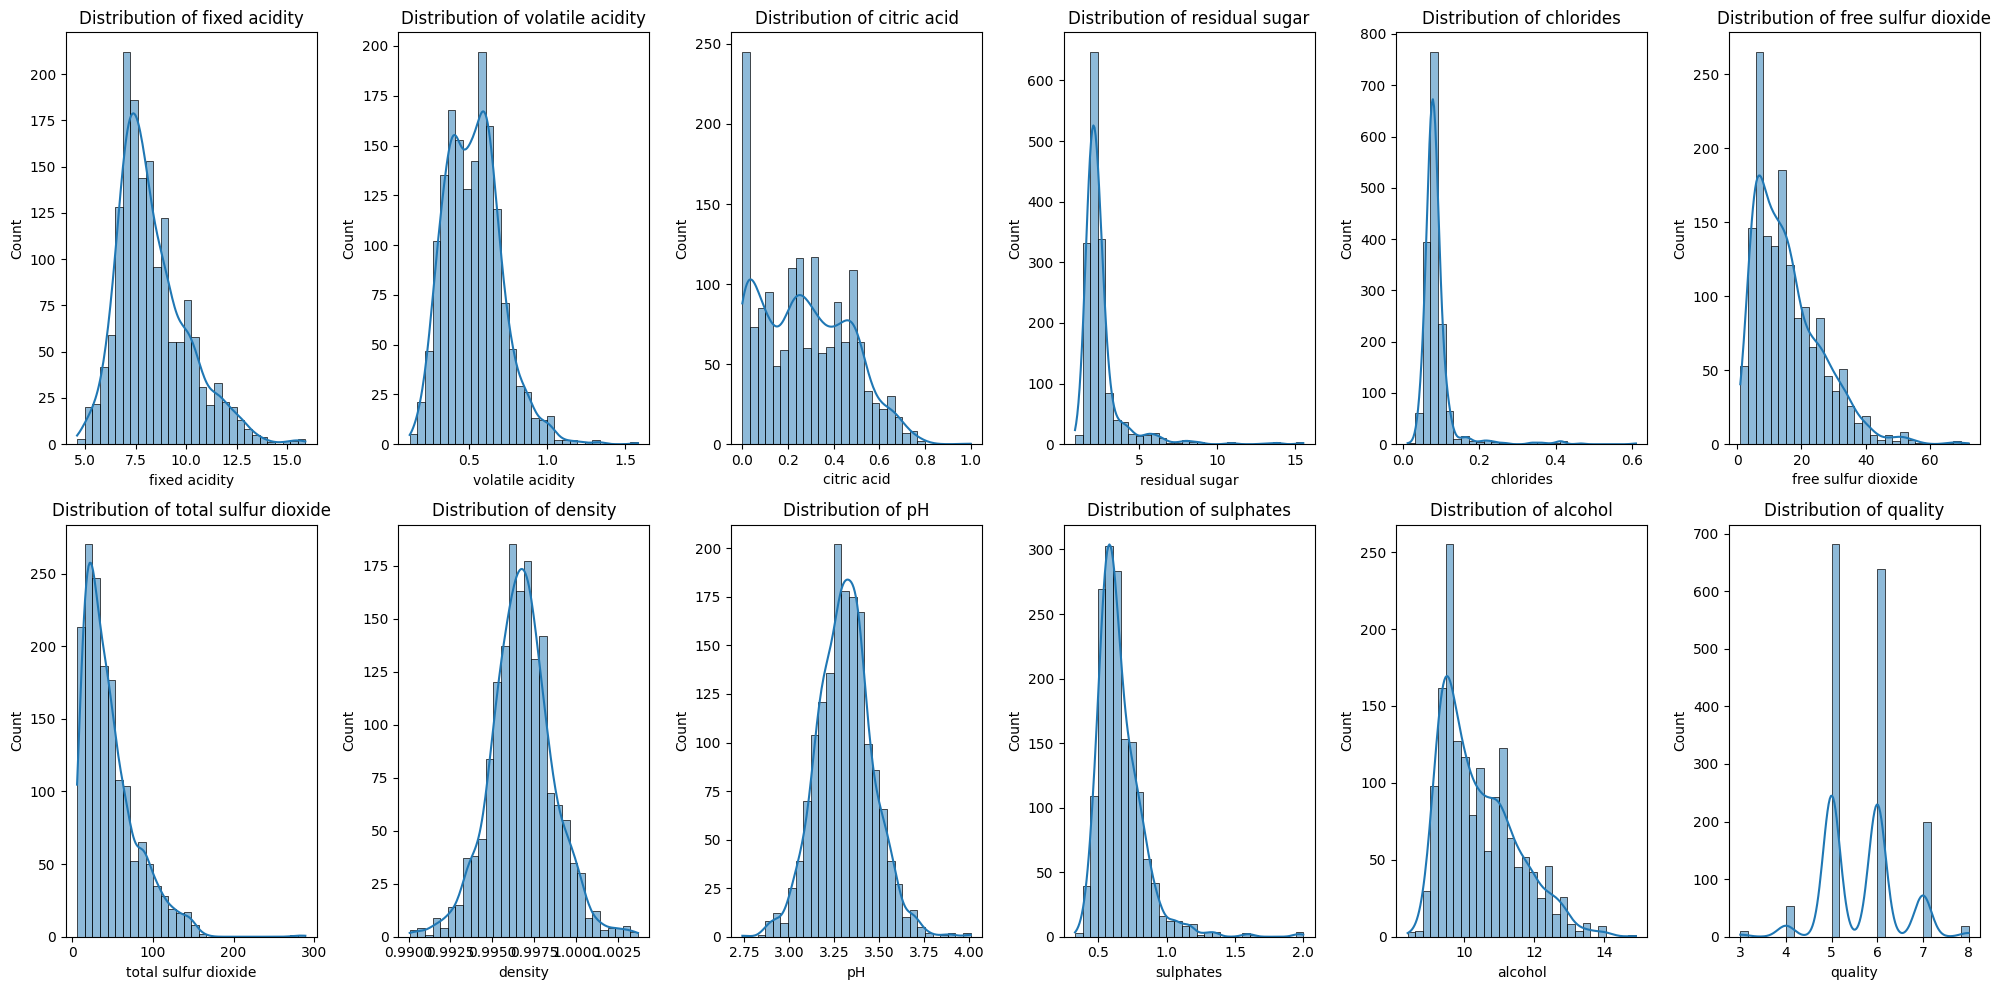

In [73]:
df_winequality_red.replace([np.inf, -np.inf], np.nan, inplace=True)

print("df_winequality_red", df_winequality_red.shape)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(df_winequality_red.columns):
    sns.histplot(df_winequality_red[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

df_winequality_red shape: (1599, 12)
df_winequality_red_filtered shape: (1565, 12)


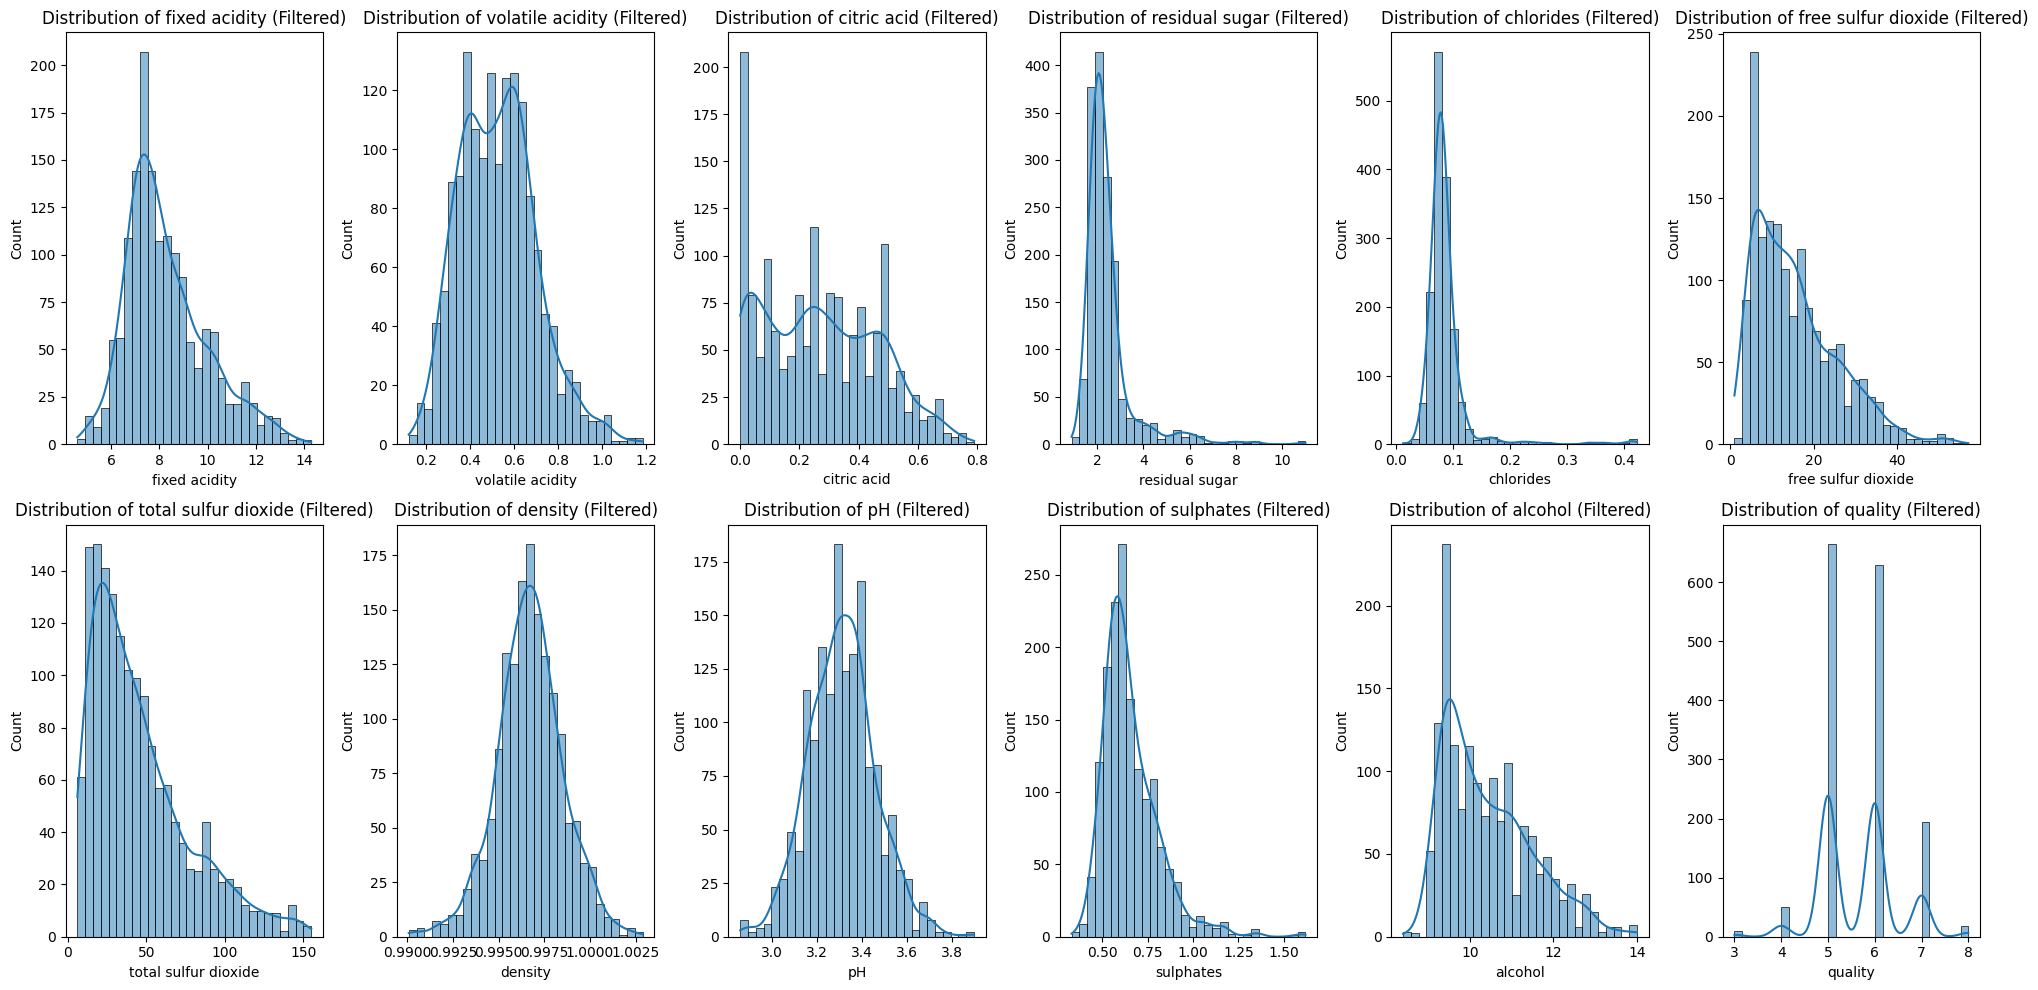

In [74]:
filters = {
    'fixed acidity': (0, 14.5),
    'volatile acidity': (0, 1.2),
    'citric acid': (0, 0.9),
    'residual sugar': (0, 12),
    'chlorides': (0, 0.45),
    'free sulfur dioxide': (0, 65),
    'total sulfur dioxide': (0, 160),
    'pH': (2.8, 4.0),
    'sulphates': (0, 1.75),
    'alcohol': (0, 14)
}

df_winequality_red_filtered = df_winequality_red.copy()
for column, (lower, upper) in filters.items():
    df_winequality_red_filtered = df_winequality_red_filtered[(df_winequality_red_filtered[column] >= lower) &
                                                              (df_winequality_red_filtered[column] <= upper)]

df_winequality_red_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

print("df_winequality_red shape:", df_winequality_red.shape)
print("df_winequality_red_filtered shape:", df_winequality_red_filtered.shape)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(df_winequality_red_filtered.columns):
    sns.histplot(df_winequality_red_filtered[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} (Filtered)')

plt.tight_layout()
plt.show()

df_winequality_red shape: (1599, 12)
df_winequality_red_filtered shape: (1565, 12)


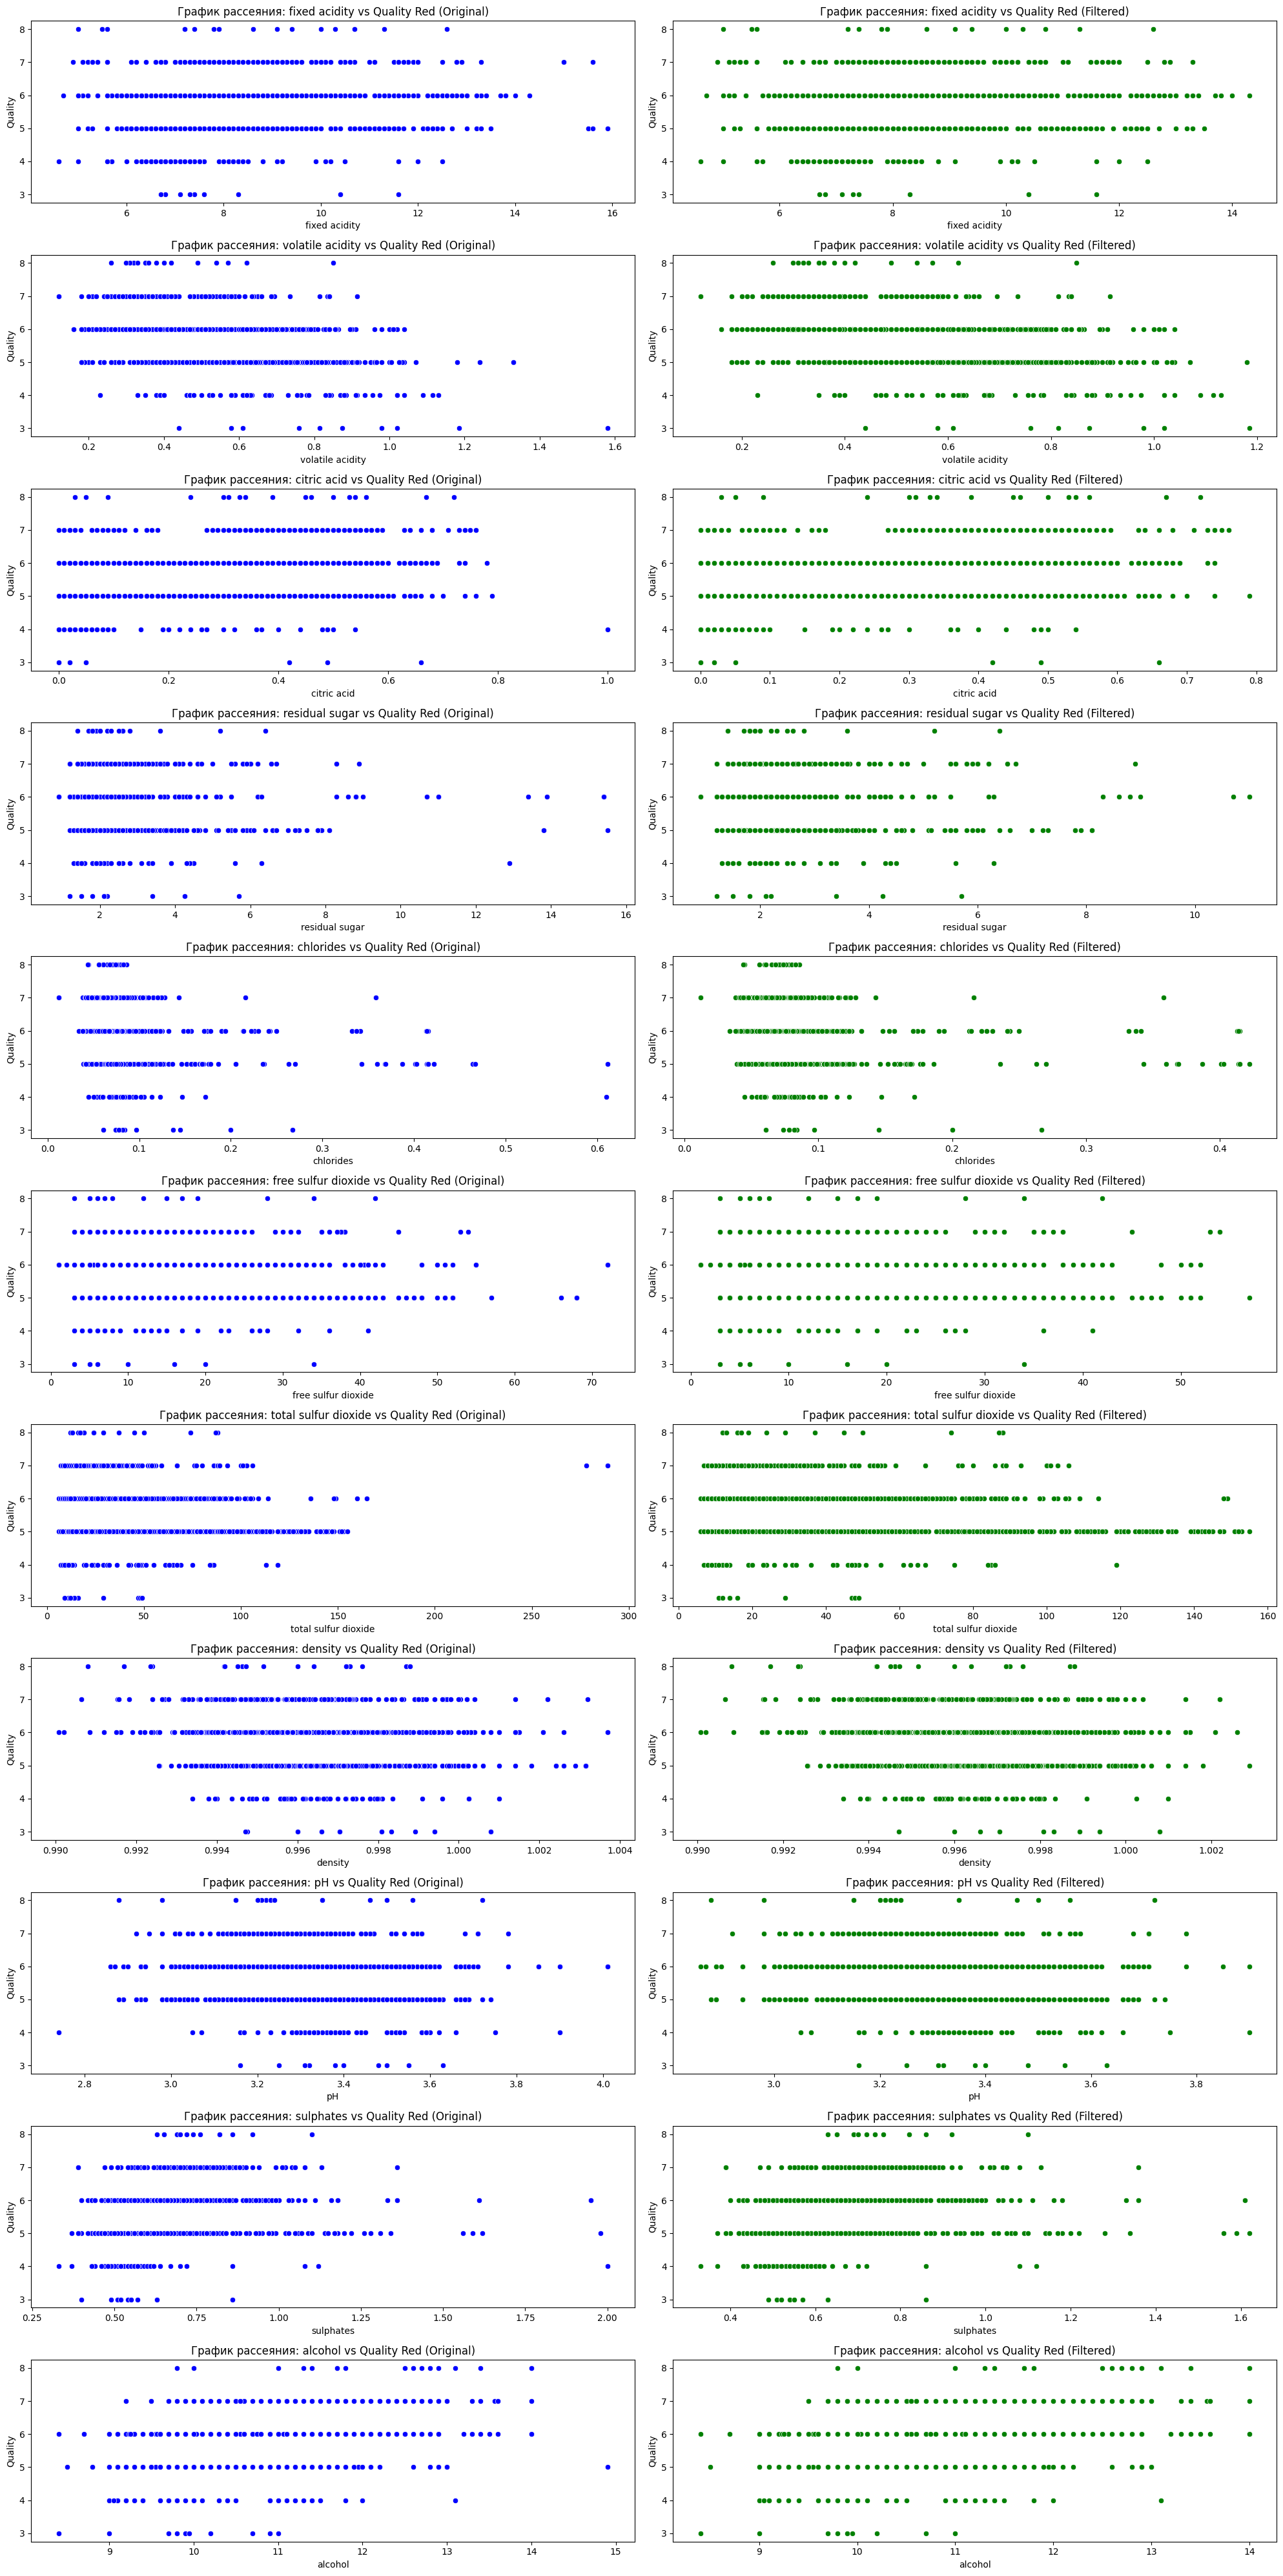

In [75]:
filters = {
    'fixed acidity': (0, 14.5),
    'volatile acidity': (0, 1.2),
    'citric acid': (0, 0.9),
    'residual sugar': (0, 12),
    'chlorides': (0, 0.45),
    'free sulfur dioxide': (0, 65),
    'total sulfur dioxide': (0, 160),
    'pH': (2.8, 4.0),
    'sulphates': (0, 1.75),
    'alcohol': (0, 14)
}

# Применение фильтров последовательно
df_winequality_red_filtered = df_winequality_red.copy()
for column, (lower, upper) in filters.items():
    df_winequality_red_filtered = df_winequality_red_filtered[(df_winequality_red_filtered[column] >= lower) &
                                                              (df_winequality_red_filtered[column] <= upper)]

# Замена бесконечных значений на NaN
df_winequality_red_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

# Проверка размеров DataFrame
print("df_winequality_red shape:", df_winequality_red.shape)
print("df_winequality_red_filtered shape:", df_winequality_red_filtered.shape)

# Построение графиков рассеяния для всех столбцов
fig, axes = plt.subplots(len(df_winequality_red.columns) - 1, 2, figsize=(20, 40))
axes = axes.flatten()

for i, column in enumerate(df_winequality_red.columns):
    if column != 'quality':
        # График рассеяния для исходного DataFrame
        sns.scatterplot(x=column, y='quality', data=df_winequality_red, color='blue', ax=axes[2 * i])
        axes[2 * i].set_title(f'График рассеяния: {column} vs Quality Red (Original)')
        axes[2 * i].set_xlabel(column)
        axes[2 * i].set_ylabel('Quality')

        # График рассеяния для отфильтрованного DataFrame
        sns.scatterplot(x=column, y='quality', data=df_winequality_red_filtered, color='green', ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f'График рассеяния: {column} vs Quality Red (Filtered)')
        axes[2 * i + 1].set_xlabel(column)
        axes[2 * i + 1].set_ylabel('Quality')

plt.tight_layout()
plt.show()

## <font color='green'>Метод решения №3 с "Удалением выбросов": <font>

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


R-squared: 0.20
Mean Absolute Error: 0.54


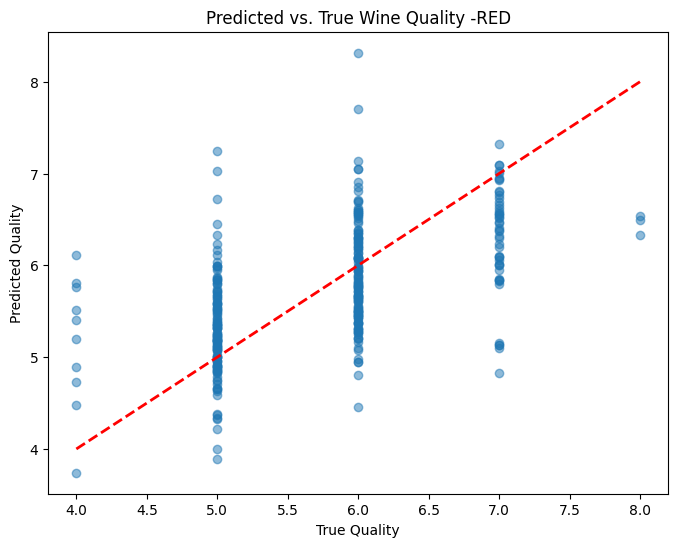

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wine_data_scaled_red2 = scaler.fit_transform(df_winequality_red_filtered.drop('quality', axis=1))
wine_data_scaled_red2 = pd.DataFrame(wine_data_scaled_red2, columns=df_winequality_red_filtered.drop('quality', axis=1).columns)
df_winequality_red_filtered['quality'] = df_winequality_red_filtered['quality']

X = wine_data_scaled_red2
y = df_winequality_red_filtered['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs. True Wine Quality -RED')
plt.show()

## <font color='green'>Метод решения №4 с "Удалением выбросов": <font>

R-squared: 0.36
Mean Absolute Error: 0.50


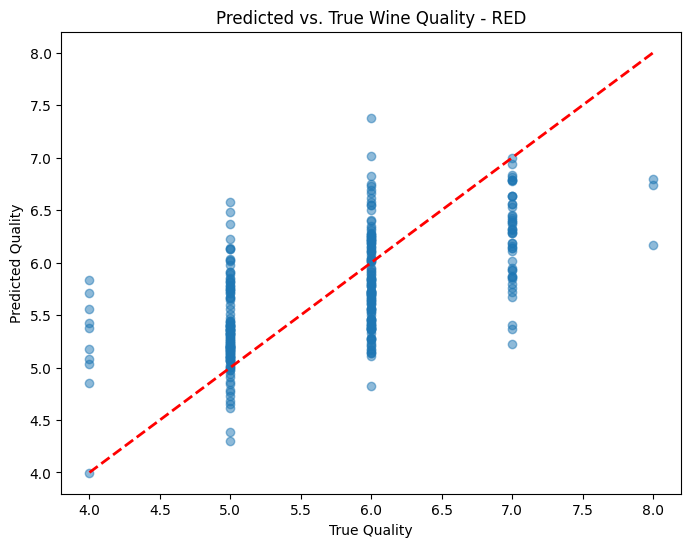

In [77]:
scaler = MinMaxScaler()
wine_data_scaled_red2 = scaler.fit_transform(df_winequality_red_filtered.drop('quality', axis=1))
wine_data_scaled_red2 = pd.DataFrame(wine_data_scaled_red2, columns=df_winequality_red_filtered.drop('quality', axis=1).columns)

df_winequality_red_filtered['quality'] = df_winequality_red_filtered['quality']

X = wine_data_scaled_red2
y = df_winequality_red_filtered['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs. True Wine Quality - RED')
plt.show()

# В результате модель стала справляться хуже (более крупные ошибки, стала меньше объяснять дисперсии). Причина: удаление важных признаков которые визуально выглядят как выброс

## <font color='green'>Метод решения №5: <font>

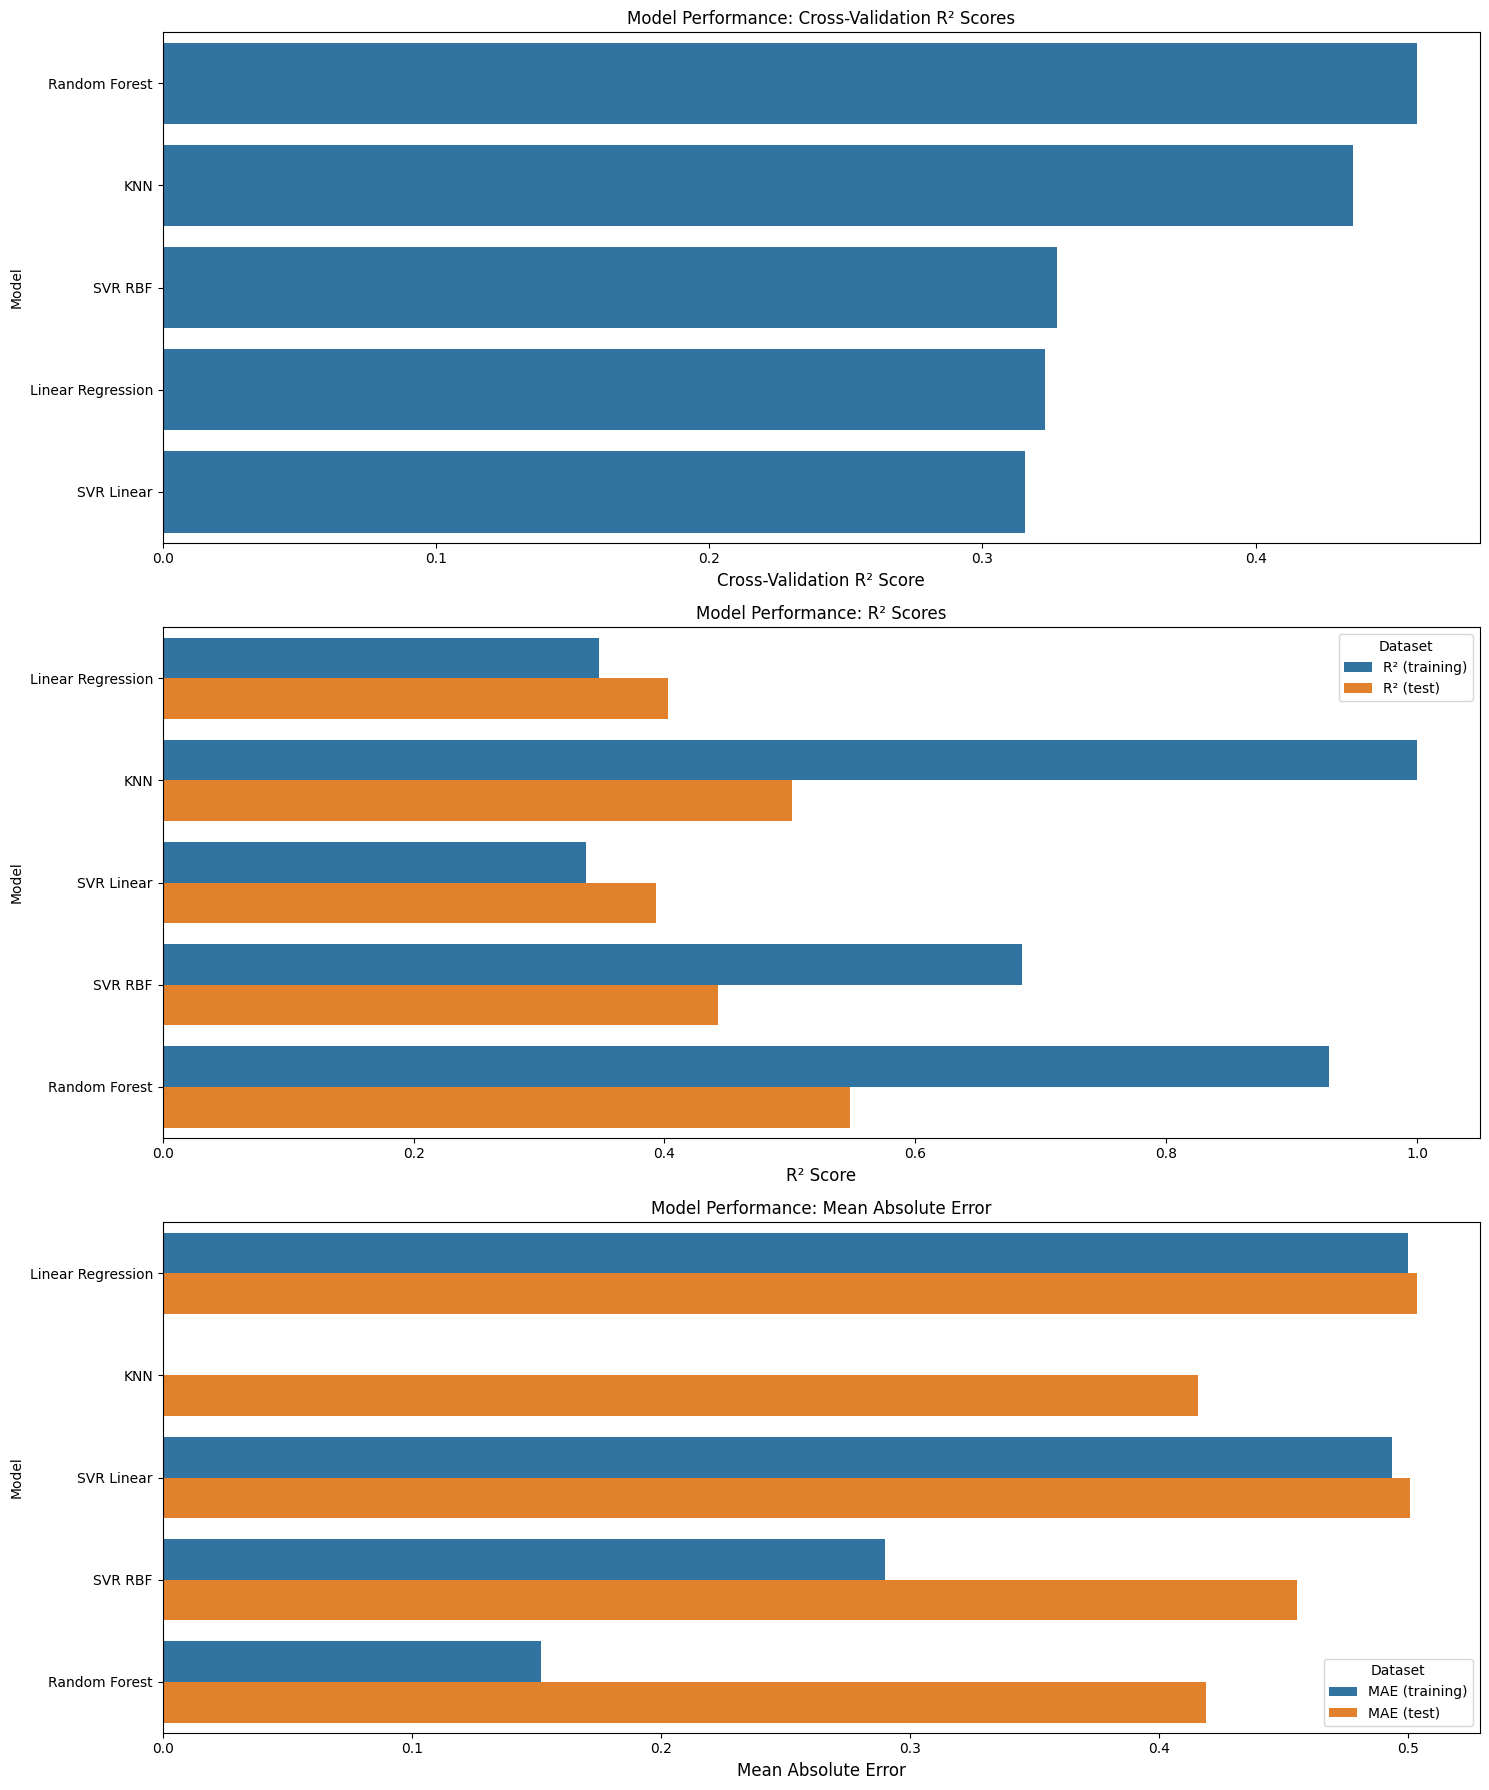


Detailed Model Performance Metrics:
               Model  CV R² Score  R² (training)  R² (test)  MAE (training)  \
0  Linear Regression       0.3230         0.3480     0.4032          0.4996   
1                KNN       0.4357         1.0000     0.5012          0.0000   
2         SVR Linear       0.3156         0.3371     0.3931          0.4933   
3            SVR RBF       0.3272         0.6851     0.4428          0.2899   
4      Random Forest       0.4592         0.9296     0.5476          0.1520   

   MAE (test)  
0      0.5035  
1      0.4156  
2      0.5007  
3      0.4552  
4      0.4187  

Analyzing red wine Quality:
Cross-validation scores: [0.23271753 0.17068201 0.31685376 0.33594759 0.17674628]
Mean CV score: 0.25 (+/- 0.14)

Метрики качества:
r2: 0.15
mae: 0.52
rmse: 0.73
mape: 10.25


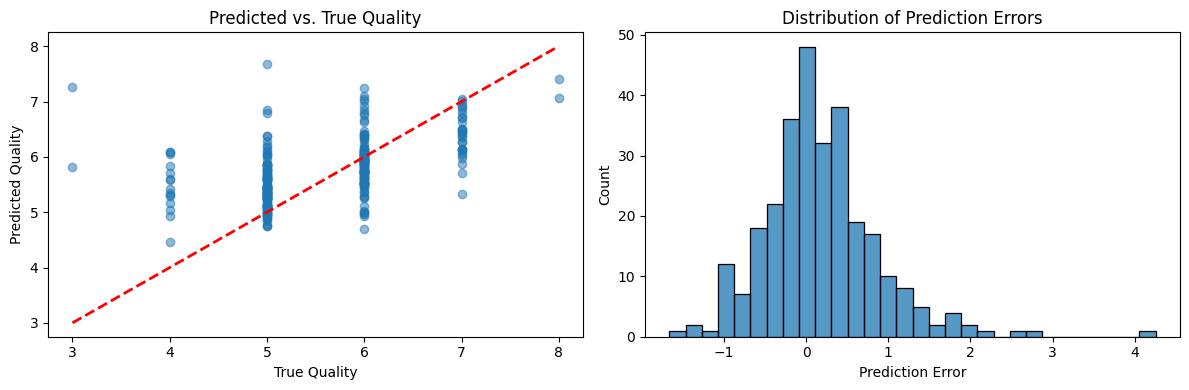


Лучшие параметры:
{'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (64, 32), 'regressor__learning_rate_init': 0.01}


In [78]:
file1 = r"/content/winequality-red.csv"
wine_data = pd.read_csv(file1, sep=';')

X = wine_data.drop(columns="quality")
y = wine_data["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    return {
        'cv_r2_mean': cv_scores.mean(),
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

results = {}

# Линейная регрессия
lr = LinearRegression()
results['Linear Regression'] = train_evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)

# K-ближайших соседей
knn = KNeighborsRegressor(n_neighbors=32, weights='distance')
results['KNN'] = train_evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test)

# SVR с линейным ядром
svr_linear = SVR(kernel='linear')
results['SVR Linear'] = train_evaluate_model(svr_linear, X_train_scaled, X_test_scaled, y_train, y_test)

# SVR с RBF ядром
svr_rbf = SVR(kernel='rbf', C=10, gamma='scale')
results['SVR RBF'] = train_evaluate_model(svr_rbf, X_train_scaled, X_test_scaled, y_train, y_test)

# Случайный лес
rf = RandomForestRegressor(n_estimators=800, max_features=4, random_state=42)
results['Random Forest'] = train_evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test)

results_df = pd.DataFrame([
    {
        'Model': model_name,
        'CV R² Score': metrics['cv_r2_mean'],
        'R² (training)': metrics['train_r2'],
        'R² (test)': metrics['test_r2'],
        'MAE (training)': metrics['train_mae'],
        'MAE (test)': metrics['test_mae']
    }
    for model_name, metrics in results.items()
])

fig, axes = plt.subplots(3, 1, figsize=(15, 18))

results_df_sorted = results_df.sort_values('CV R² Score', ascending=False)
sns.barplot(x='CV R² Score', y='Model', data=results_df_sorted, ax=axes[0])
axes[0].set_xlabel('Cross-Validation R² Score', size=12)
axes[0].set_title('Model Performance: Cross-Validation R² Scores')

results_melted = pd.melt(results_df,
                        id_vars=['Model'],
                        value_vars=['R² (training)', 'R² (test)'],
                        var_name='Dataset',
                        value_name='R² Score')
sns.barplot(x='R² Score', y='Model', hue='Dataset', data=results_melted, ax=axes[1])
axes[1].set_xlabel('R² Score', size=12)
axes[1].set_title('Model Performance: R² Scores')

results_melted = pd.melt(results_df,
                        id_vars=['Model'],
                        value_vars=['MAE (training)', 'MAE (test)'],
                        var_name='Dataset',
                        value_name='MAE')
sns.barplot(x='MAE', y='Model', hue='Dataset', data=results_melted, ax=axes[2])
axes[2].set_xlabel('Mean Absolute Error', size=12)
axes[2].set_title('Model Performance: Mean Absolute Error')

plt.tight_layout()
plt.show()

print("\nDetailed Model Performance Metrics:")
print(results_df.round(4))

def detect_and_remove_outliers(X, y, contamination=0.1):
    """
    Обнаружение и удаление выбросов с использованием IsolationForest
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    yhat = iso_forest.fit_predict(X)
    mask = yhat != -1
    return X[mask], y[mask]

def create_wine_features(df):
    """
    Создание признаков с дополнительными преобразованиями
    """
    df = df.copy()

    df['total_acidity'] = df['fixed acidity'] + df['volatile acidity']
    df['sugar_to_acid_ratio'] = df['residual sugar'] / df['total_acidity']
    df['free_to_total_so2_ratio'] = df['free sulfur dioxide'] / df['total sulfur dioxide']

    X = df.drop('quality', axis=1)
    y = df['quality']

    return X, y

def create_wine_pipeline(param_grid=None):
    """
    Создание пайплайна с возможностью настройки параметров
    """
    numeric_features = ['fixed acidity', 'volatile acidity', 'citric acid',
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
                       'total_acidity', 'sugar_to_acid_ratio', 'free_to_total_so2_ratio']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features)
        ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(64, 32),
                                 activation='relu',
                                 solver='adam',
                                 max_iter=1000,
                                 random_state=42))
    ])

    if param_grid:
        pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

    return pipeline

def evaluate_predictions(y_true, y_pred):
    """
    Расширенная оценка качества предсказаний
    """
    results = {
        'r2': r2_score(y_true, y_pred),
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

    return results

def train_and_evaluate_model(X, y, pipeline):
    """
    Обучение и оценка модели с кросс-валидацией
    """
    X_clean, y_clean = detect_and_remove_outliers(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    metrics = evaluate_predictions(y_test, y_pred)
    print("\nМетрики качества:")
    for metric, value in metrics.items():
        print(f'{metric}: {value:.2f}')

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('True Quality')
    plt.ylabel('Predicted Quality')
    plt.title('Predicted vs. True Quality')

    plt.subplot(1, 2, 2)
    errors = y_pred - y_test
    sns.histplot(errors, bins=30)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Prediction Error')

    plt.tight_layout()
    plt.show()

    return pipeline, (X_test, y_test, y_pred)

def main():
    param_grid = {
        'regressor__hidden_layer_sizes': [(32, 16), (64, 32), (128, 64)],
        'regressor__alpha': [0.0001, 0.001, 0.01],
        'regressor__learning_rate_init': [0.001, 0.01]
    }

    file1 = r"/content/winequality-red.csv"
    df_winequality_red = pd.read_csv(file1, sep=';')

    results = {}
    for wine_type, df in [('red_wine', df_winequality_red),]:
        print(f"\nAnalyzing {wine_type.replace('_', ' ')} Quality:")

        X, y = create_wine_features(df)

        pipeline = create_wine_pipeline(param_grid)
        model, evaluation_results = train_and_evaluate_model(X, y, pipeline)

        results[wine_type] = {
            'model': model,
            'results': evaluation_results
        }

        if hasattr(model, 'best_params_'):
            print("\nЛучшие параметры:")
            print(model.best_params_)

    return results

if __name__ == "__main__":
    results = main()

## <font color='green'>Метод решения №6": <font>

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 27.6162 - val_loss: 18.1942
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.0371 - val_loss: 5.4245
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8159 - val_loss: 1.9210
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1783 - val_loss: 1.7398
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7490 - val_loss: 1.6400
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6879 - val_loss: 1.5105
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4348 - val_loss: 1.4428
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4279 - val_loss: 1.3620
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2734 - val_loss: 1.3259
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2873 - val_loss: 1.2500
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2573 - val_loss: 1.1963
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1650 - va

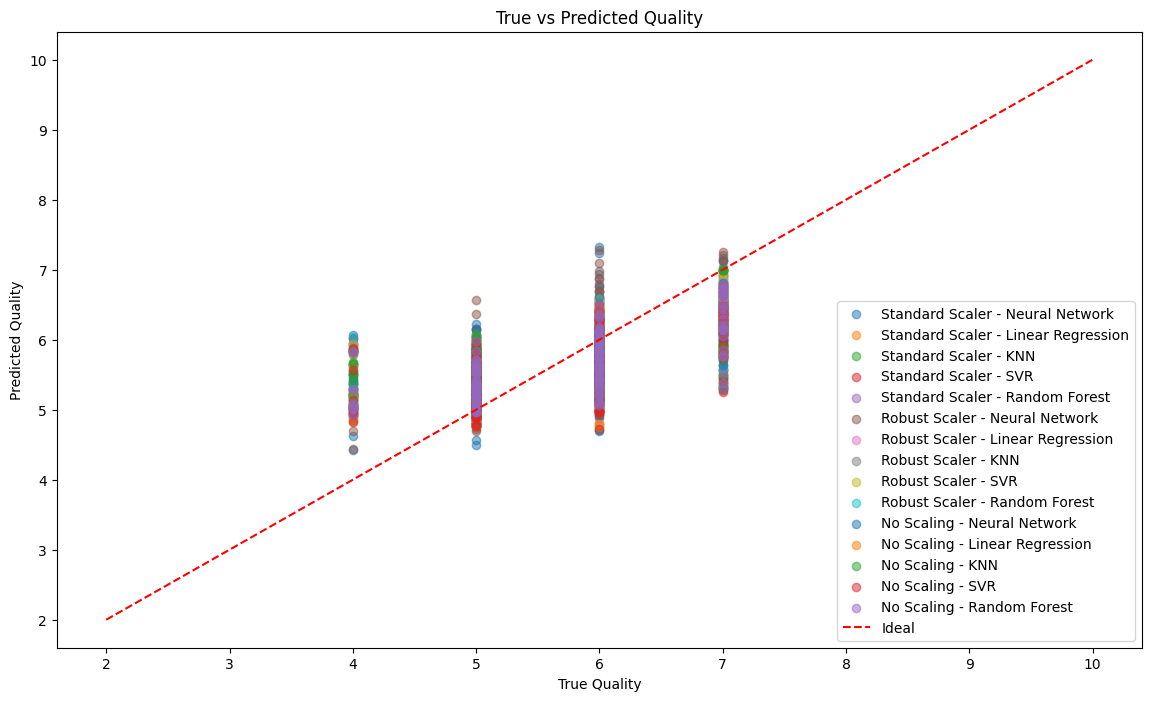

In [79]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

def normalize_data(X, scaler):
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2, y_pred

def visualize_results(results, y_test):
    plt.figure(figsize=(14, 8))
    for result in results:
        plt.scatter(y_test, result['y_pred'], alpha=0.5, label=f"{result['Method']} - {result['Model']}")
    plt.plot([2, 10], [2, 10], 'r--', label='Ideal')
    plt.xlabel('True Quality')
    plt.ylabel('Predicted Quality')
    plt.title('True vs Predicted Quality')
    plt.legend()
    plt.show()

file1 = r"/content/winequality-red.csv"
df = pd.read_csv(file1, sep=';')

df = remove_outliers(df)

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

methods = [
    ('StandardScaler', StandardScaler(), 'Standard Scaler'),
    ('RobustScaler', RobustScaler(), 'Robust Scaler'),
    ('No Scaling', None, 'No Scaling')
]

models = [
    ('Neural Network', build_model(X_train.shape[1]), train_model),
    ('Linear Regression', LinearRegression(), lambda model, X_train, y_train, X_val, y_val: model.fit(X_train, y_train)),
    ('KNN', KNeighborsRegressor(n_neighbors=32, weights='distance'), lambda model, X_train, y_train, X_val, y_val: model.fit(X_train, y_train)),
    ('SVR', SVR(kernel='linear'), lambda model, X_train, y_train, X_val, y_val: model.fit(X_train, y_train)),
    ('Random Forest', RandomForestRegressor(n_estimators=800, max_features=4, random_state=42), lambda model, X_train, y_train, X_val, y_val: model.fit(X_train, y_train))
]

results = []

for method_name, scaler, method_title in methods:
    if scaler:
        X_train_scaled = normalize_data(X_train, scaler)
        X_val_scaled = normalize_data(X_val, scaler)
        X_test_scaled = normalize_data(X_test, scaler)
    else:
        X_train_scaled = X_train
        X_val_scaled = X_val
        X_test_scaled = X_test

    for model_name, model, train_func in models:
        if model_name == 'Neural Network':
            history = train_func(model, X_train_scaled, y_train, X_val_scaled, y_val)
        else:
            train_func(model, X_train_scaled, y_train, X_val_scaled, y_val)
            history = None

        mae, r2, y_pred = evaluate_model(model, X_test_scaled, y_test)
        results.append({
            'Method': method_title,
            'Model': model_name,
            'MAE': mae,
            'R2': r2,
            'y_pred': y_pred
        })

results_df = pd.DataFrame([{
    'Method': result['Method'],
    'Model': result['Model'],
    'MAE': result['MAE'],
    'R2': result['R2']
} for result in results])
print(results_df)

visualize_results(results, y_test)

## <font color='green'>Метод решения №7": <font>

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 11.2641 - mean_absolute_error: 2.3970 - val_loss: 0.7192 - val_mean_absolute_error: 0.6777
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6505 - mean_absolute_error: 0.6237 - val_loss: 0.5134 - val_mean_absolute_error: 0.5746
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5649 - mean_absolute_error: 0.5836 - val_loss: 0.6196 - val_mean_absolute_error: 0.6174
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5514 - mean_absolute_error: 0.5714 - val_loss: 0.4885 - val_mean_absolute_error: 0.5527
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4901 - mean_absolute_error: 0.5340 - val_loss: 0.4698 - val_mean_absolute_error: 0.5484
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5554 - mean_absolute_error: 0.5718 - val_loss: 0.4823 - val_mean_absolute_error: 0.5412
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5157 - mean_absolute_error: 0.5517 - val_loss: 0.4720 - val_m

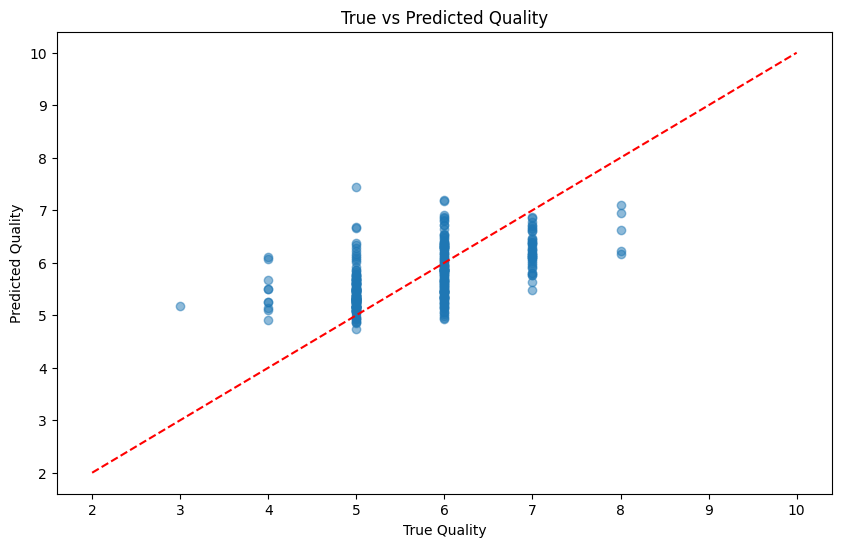

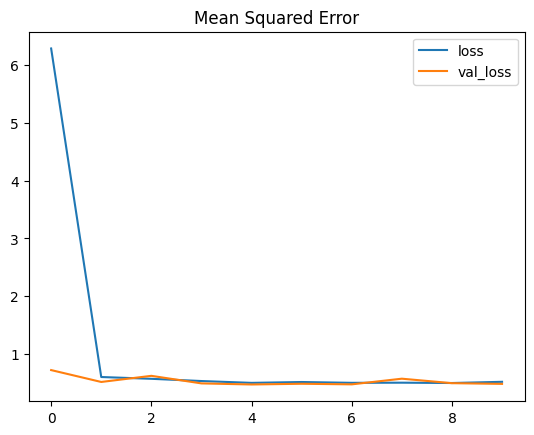

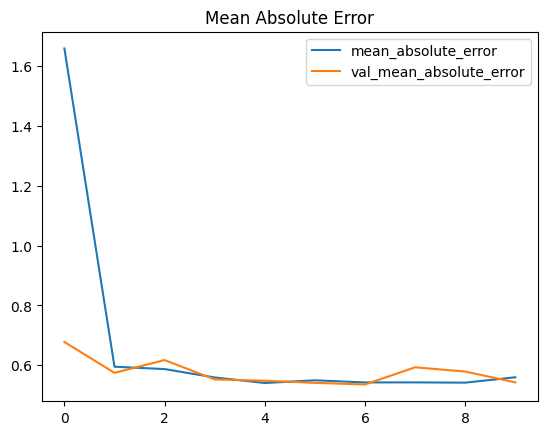

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers

file1 = r"/content/winequality-red.csv"
df = pd.read_csv(file1, sep=';')

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(128, input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='linear')
])

early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=50,
    epochs=50,
    callbacks=[early_stop]
)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([2, 10], [2, 10], 'r--')
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('True vs Predicted Quality')
plt.show()

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Mean Squared Error")
history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']].plot(title="Mean Absolute Error")
plt.show()